# Feature Engineering Notebook

## Objectives

* Drop features that are correlated with other features
* Transform continuous variables


## Inputs

* outputs/datasets/collection/HousePricesRecords.csv

## Outputs

* Generate a pipeline including data cleaning and feature engineering

## Conclusions

* Six more features could be dropped leaving 15 features out of the original 23 (two were dropped in the data cleaning step).
* The numerical transformations significantly improved the distribution of two variables including the target (the sale price)

---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Project-heritage-housing-issues'

## Load Cleaned Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv"))
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0


## SmartCorrelatedSelection Variables

* Add SmartCorrelatedSelection to the pipeline to drop features that are correlated with other features and therefore do not add any new information

In [5]:
from sklearn.pipeline import Pipeline

# Pipeline steps needed
### Drop features
from feature_engine.selection import DropFeatures

### Median Imputer
from feature_engine.imputation import MeanMedianImputer

### Correlation selection
from feature_engine.selection import SmartCorrelatedSelection

In [6]:
# Custom Encoder from DataCleaning notebook
from sklearn.base import BaseEstimator, TransformerMixin
class MyCustomEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, variables, dic):
    if not isinstance(variables, list): 
      self.variables = [variables]
    else: self.variables = variables
    self.dic = dic

  def fit(self, X, y=None):    
    return self

  def transform(self, X):
    for col in self.variables:
      if X[col].dtype == 'object':
        X[col] = X[col].replace(dic[col])
      else:
        print(f"Warning: {col} data type should be object to use MyCustomEncoder()")
      
    return X

In [7]:
# dic and vars_with_missing_data is needed for data cleaning - See the DataCleaning notebook
df2 = df.copy().drop('SalePrice', axis=1)
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']

from feature_engine.selection import SmartCorrelatedSelection

pipeline = Pipeline([
      ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
      ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),
      ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
      ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance"))
])

df_transformed = pipeline.fit_transform(df2) 
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BedroomAbvGr  1460 non-null   float64
 1   BsmtExposure  1422 non-null   float64
 2   BsmtFinSF1    1460 non-null   float64
 3   BsmtUnfSF     1460 non-null   float64
 4   GarageArea    1460 non-null   float64
 5   GarageFinish  1460 non-null   float64
 6   GrLivArea     1460 non-null   float64
 7   LotArea       1460 non-null   float64
 8   LotFrontage   1460 non-null   float64
 9   MasVnrArea    1460 non-null   float64
 10  OpenPorchSF   1460 non-null   float64
 11  OverallCond   1460 non-null   int64  
 12  OverallQual   1460 non-null   int64  
 13  TotalBsmtSF   1460 non-null   float64
 14  YearBuilt     1460 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 171.2 KB


* Show the groups with correlated features

In [8]:
pipeline['corr_sel'].correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'BsmtFinSF1', 'BsmtFinType1'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'},
 {'KitchenQual', 'OverallQual'}]

* Show the removed features

In [9]:
pipeline['corr_sel'].features_to_drop_

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinType1',
 'GarageYrBlt',
 'KitchenQual',
 'YearRemodAdd']

##  Transform numerical variables
Custom code from Code Institute Scikit-learn module

In [10]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')



def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

* The variables remaining after the previous pipeline are:

In [11]:
variables_after_corr_sel = df_transformed.columns.to_list()
variables_after_corr_sel

['BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

* The tranformations can only be applied to continuous variables, leaving nine out of 15

In [14]:
variables_engineering = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']

In [15]:
df_engineering = df_transformed[variables_engineering].copy()
df_engineering.head(3)

,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,TotalBsmtSF
0,706.0,150.0,548.0,1710.0,8450.0,65.0,196.0,61.0,856.0
1,978.0,284.0,460.0,1262.0,9600.0,80.0,0.0,0.0,1262.0
2,486.0,434.0,608.0,1786.0,11250.0,68.0,162.0,42.0,920.0


* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



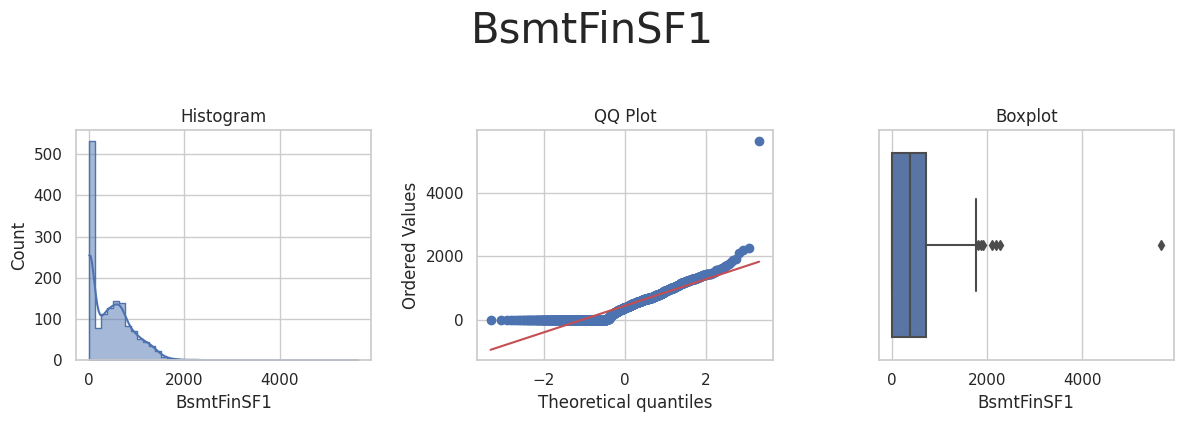

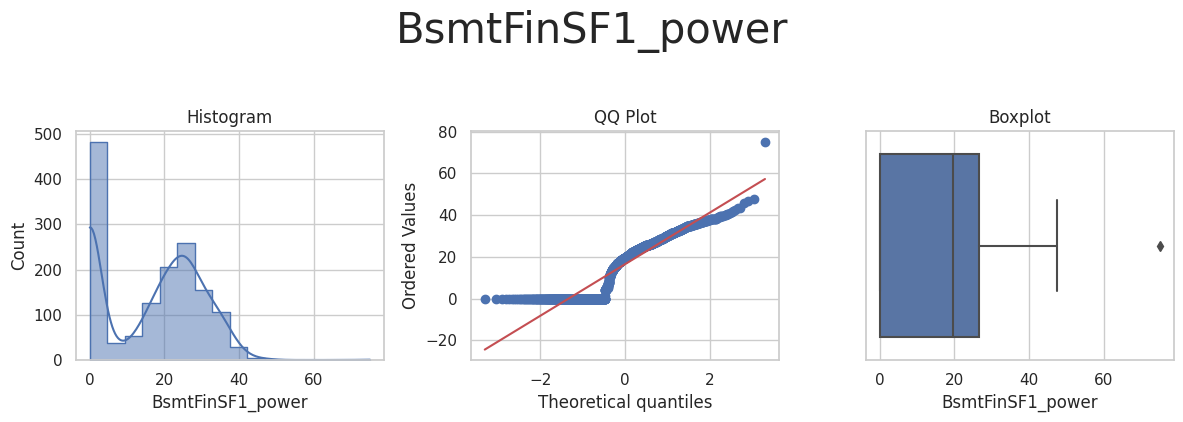

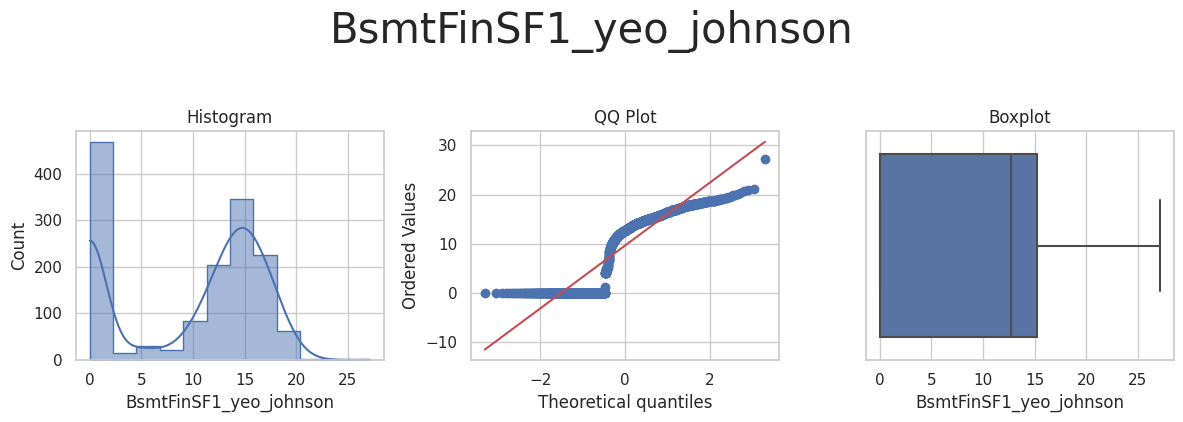



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



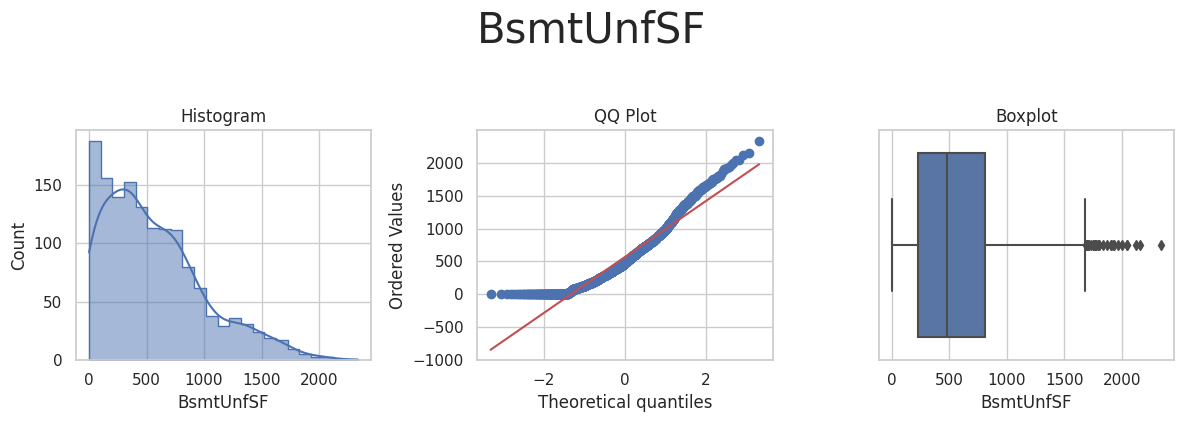

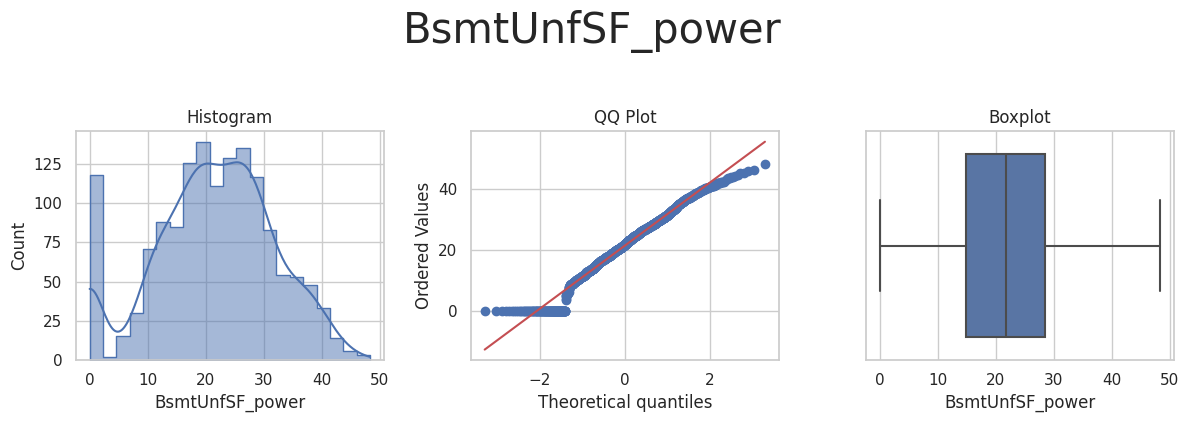

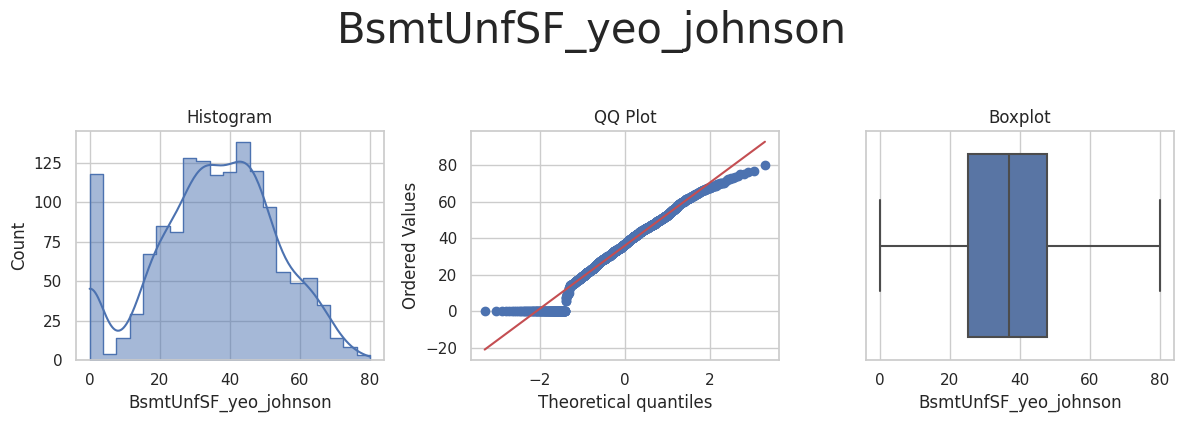



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



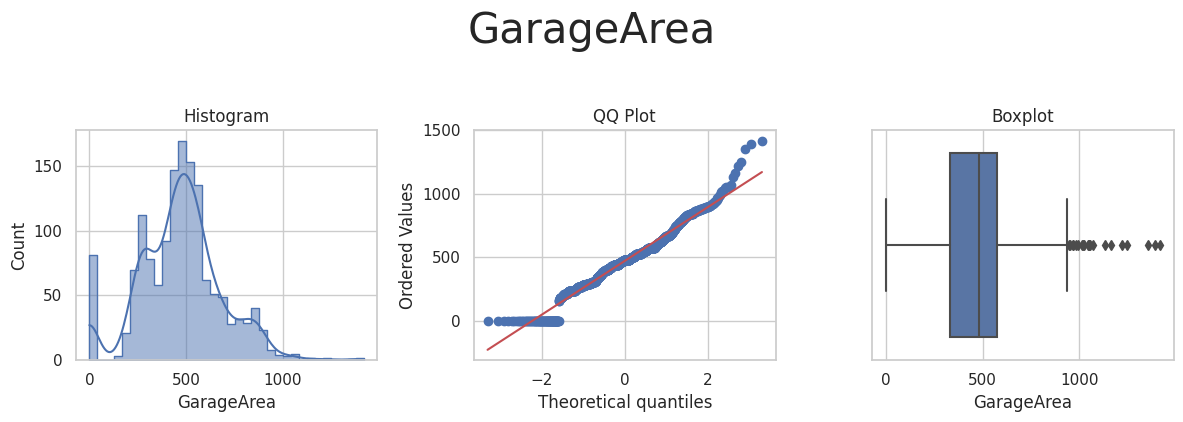

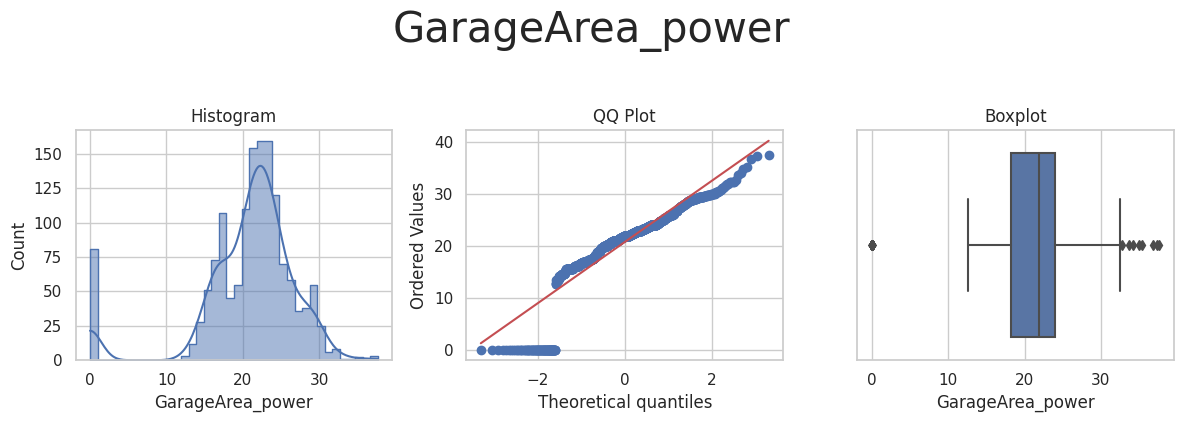

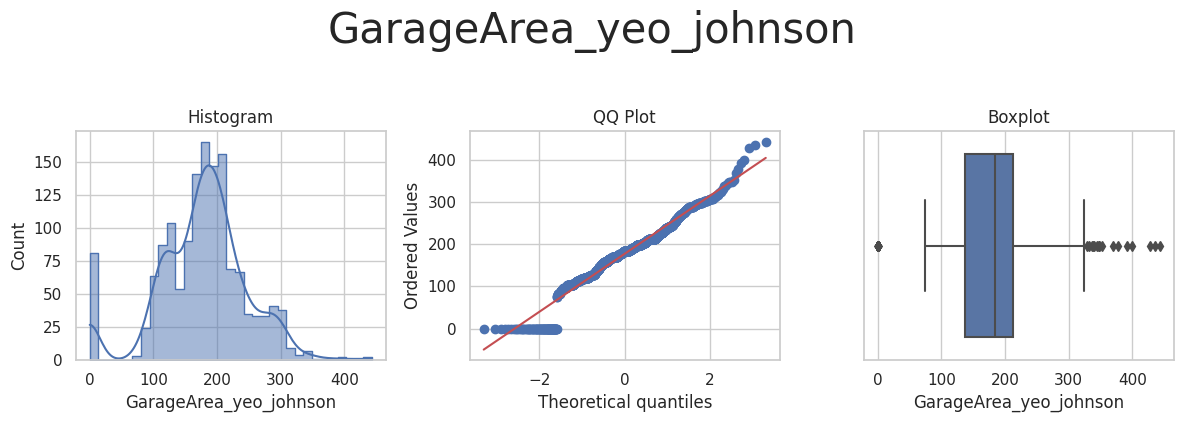



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



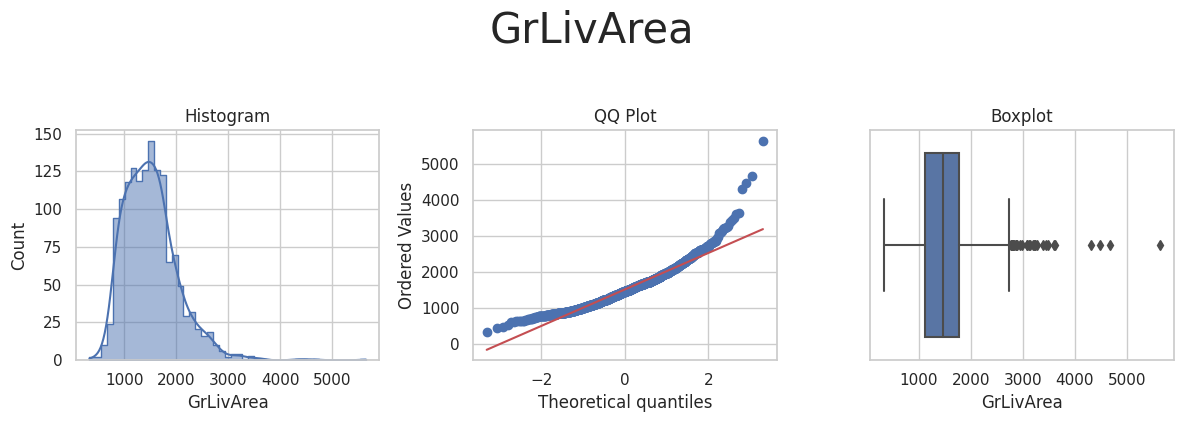

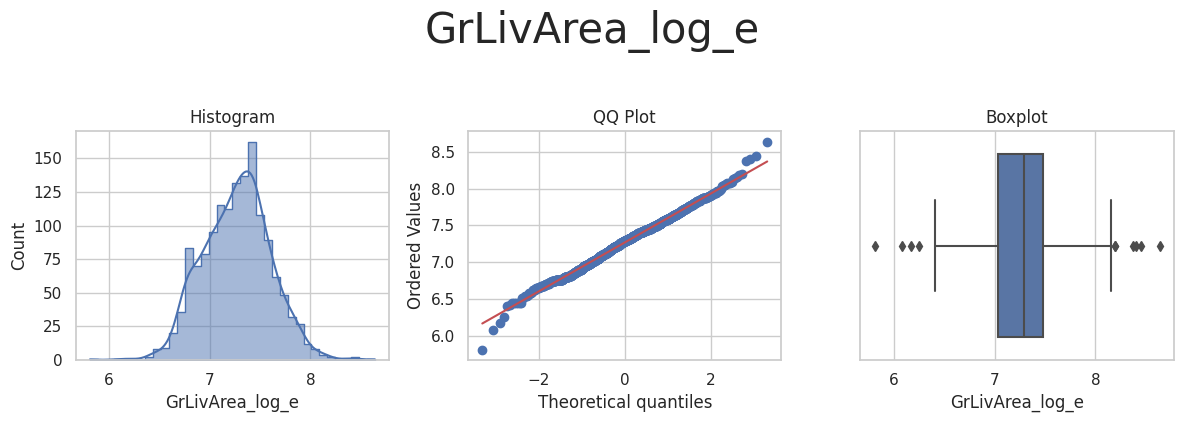

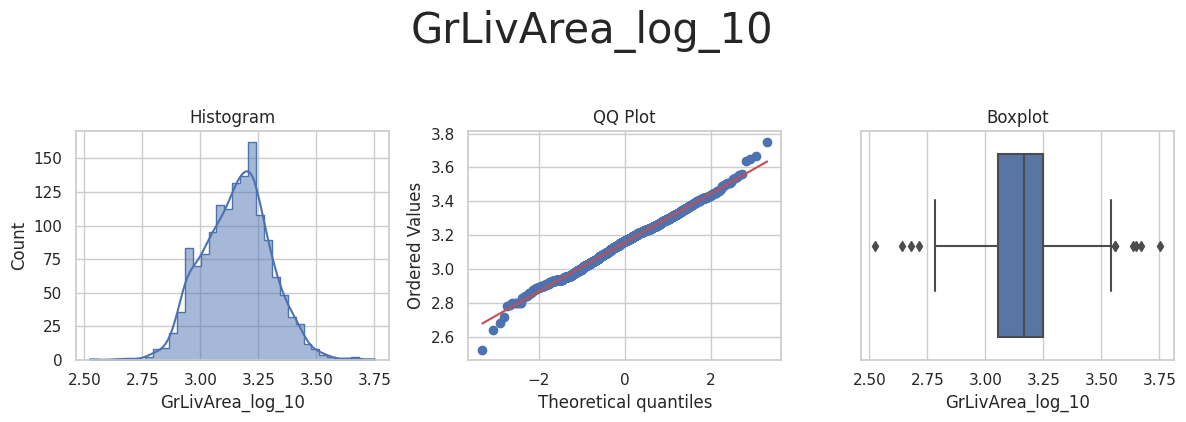

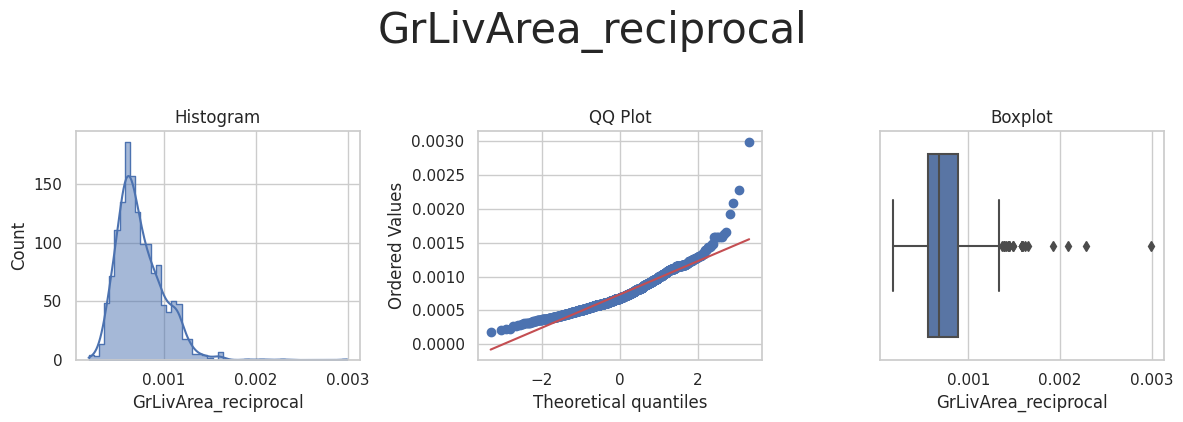

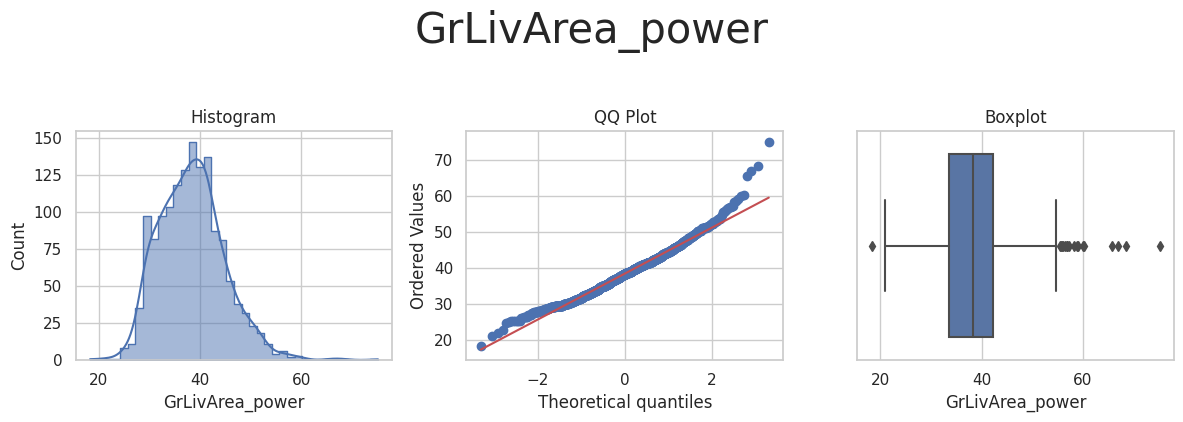

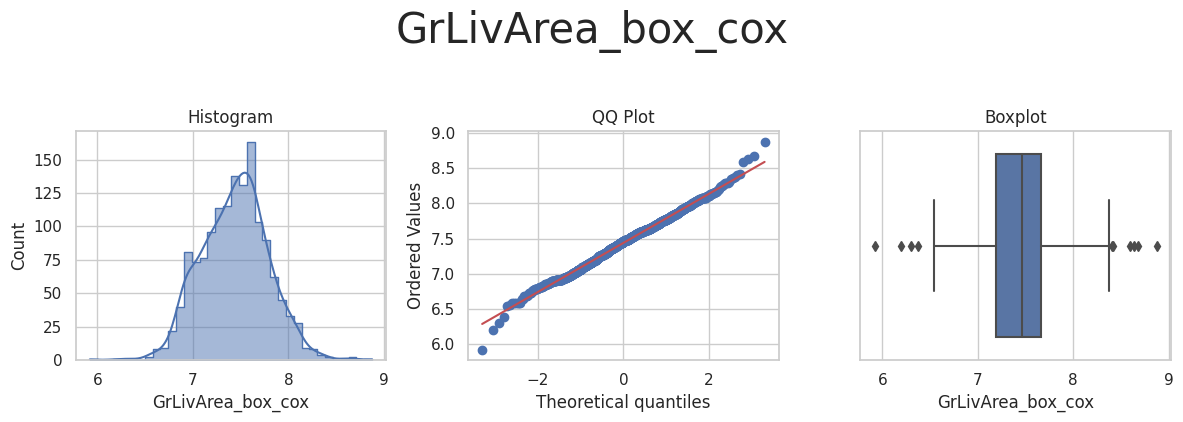

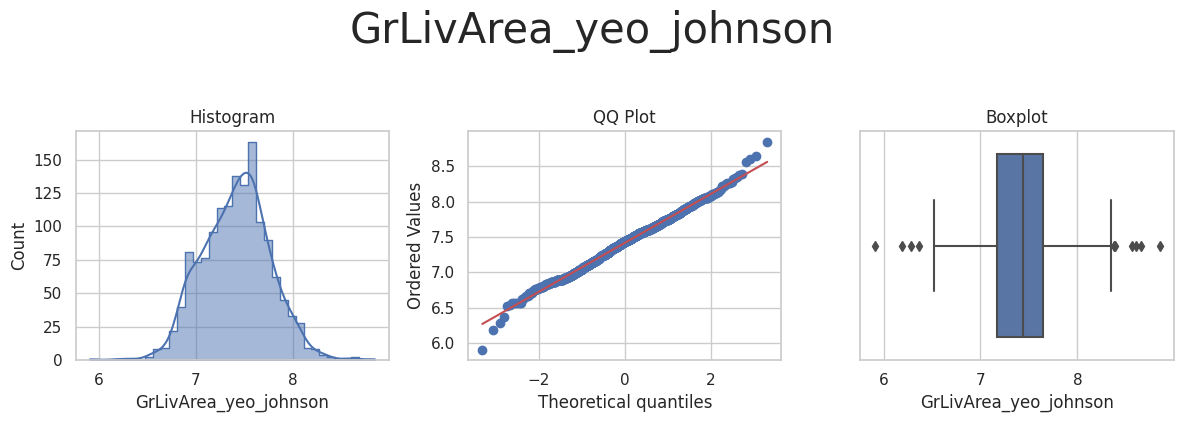



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



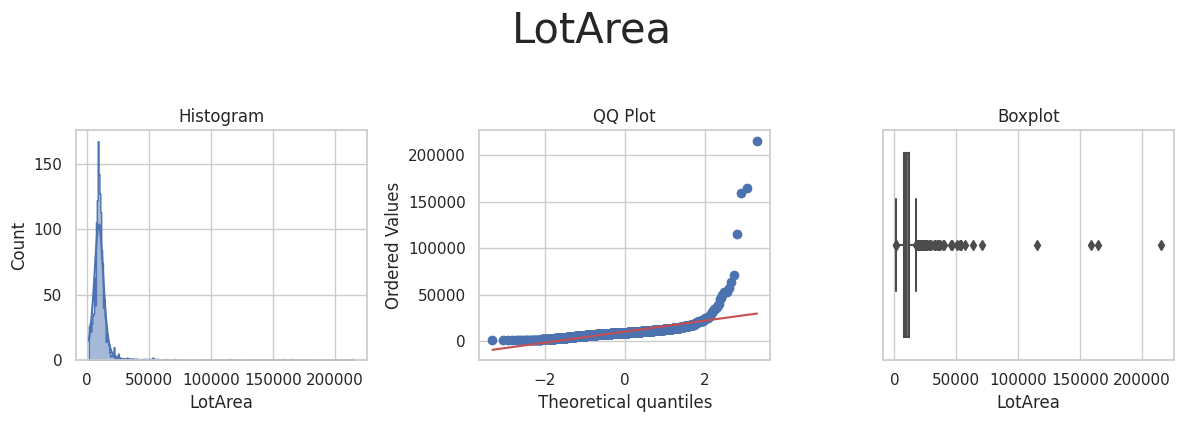

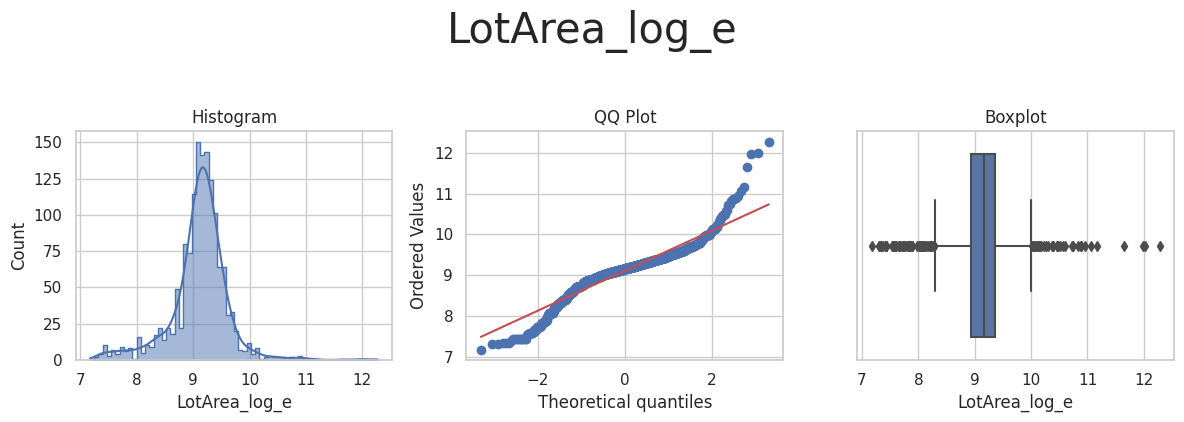

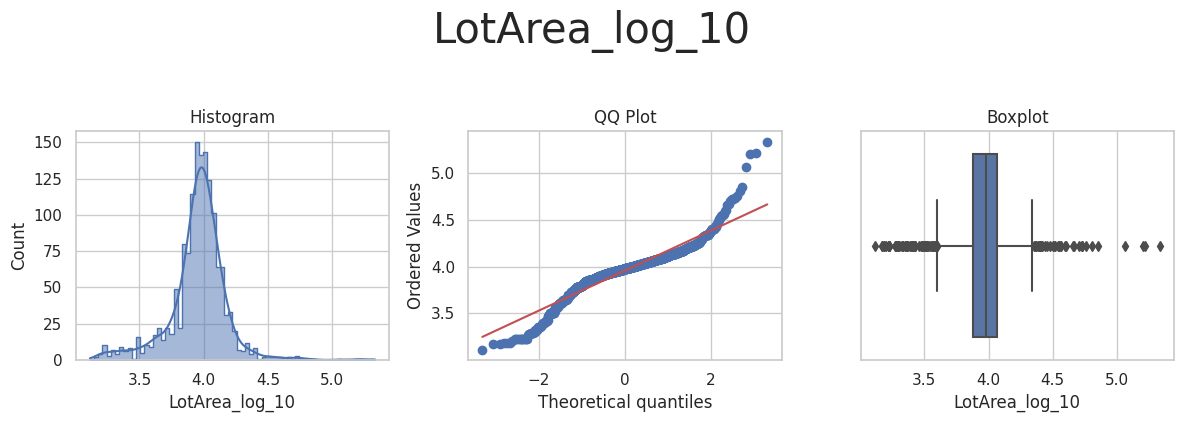

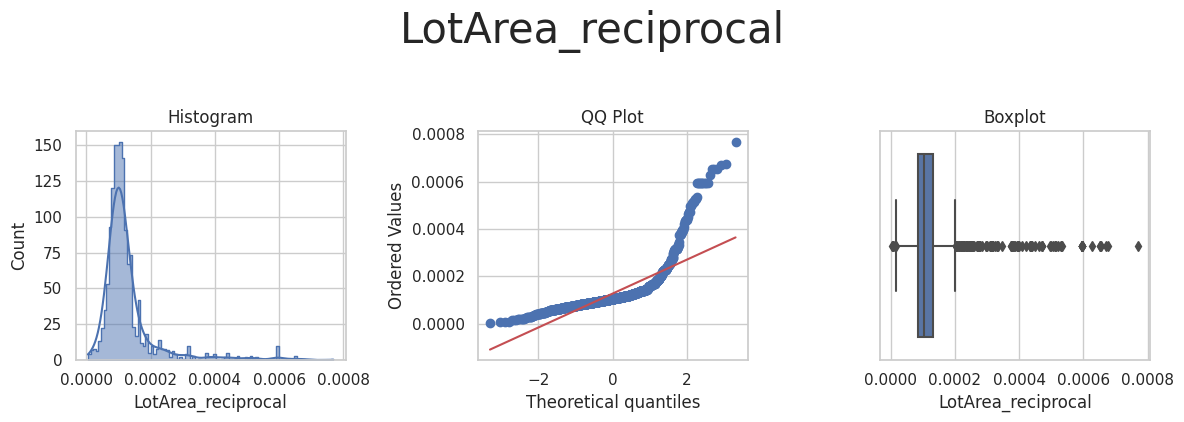

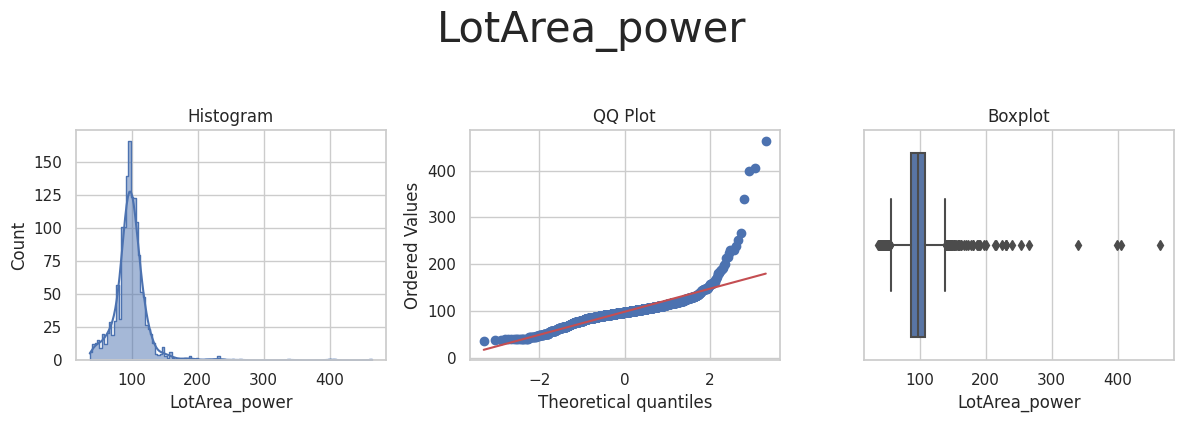

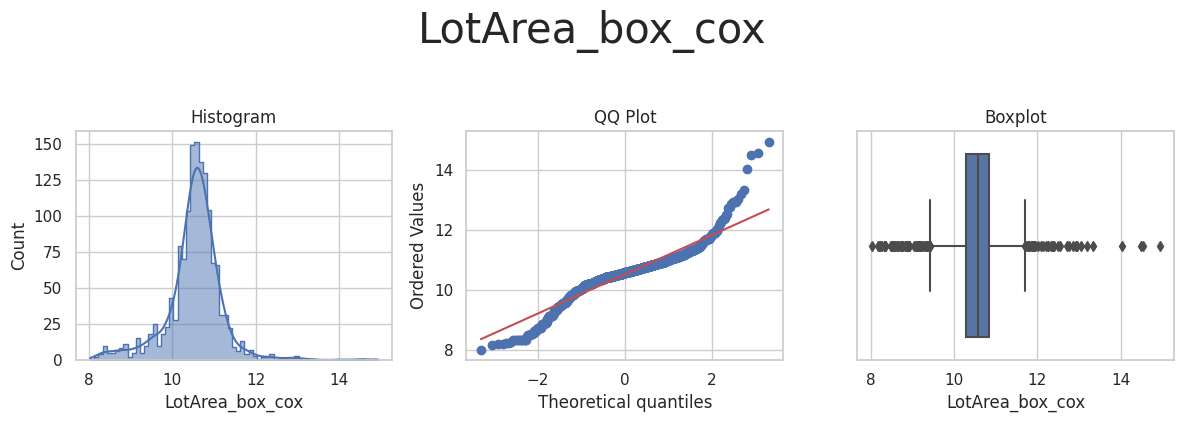

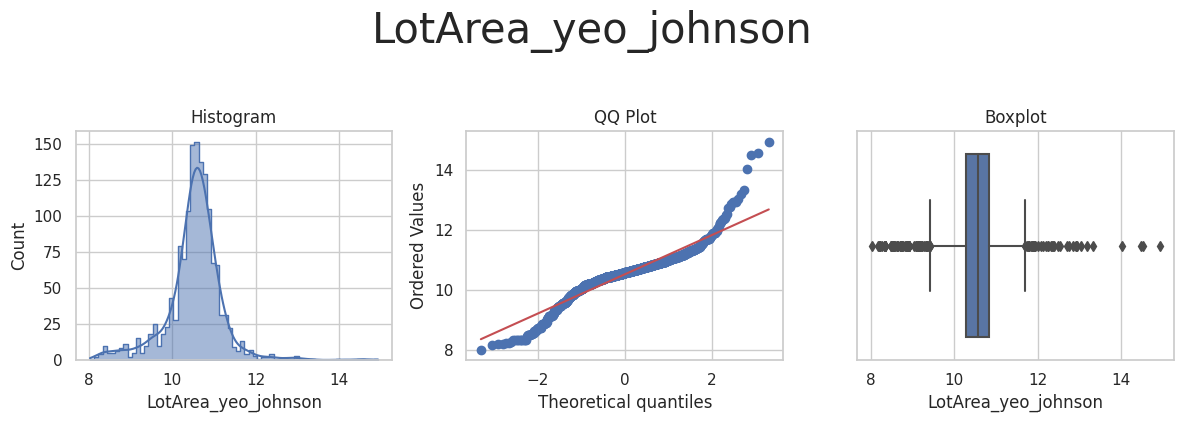



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



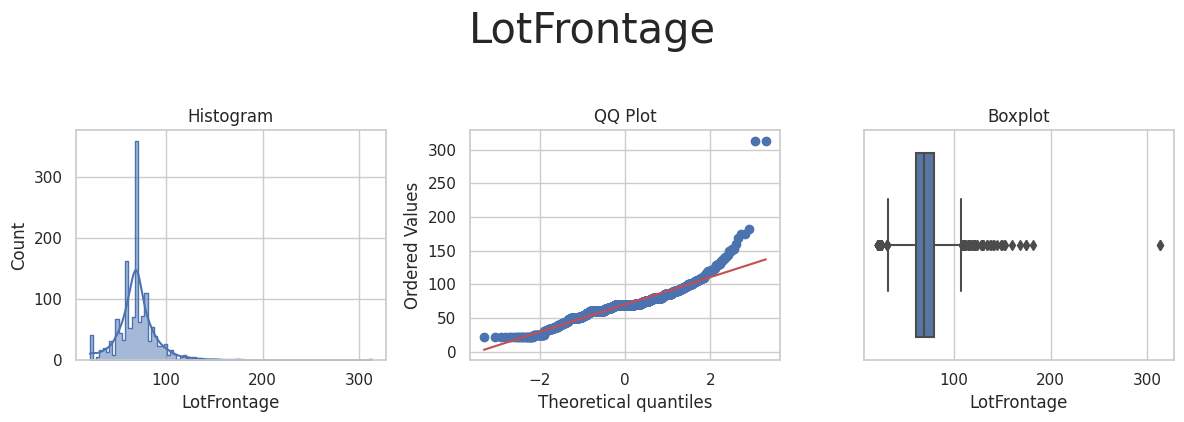

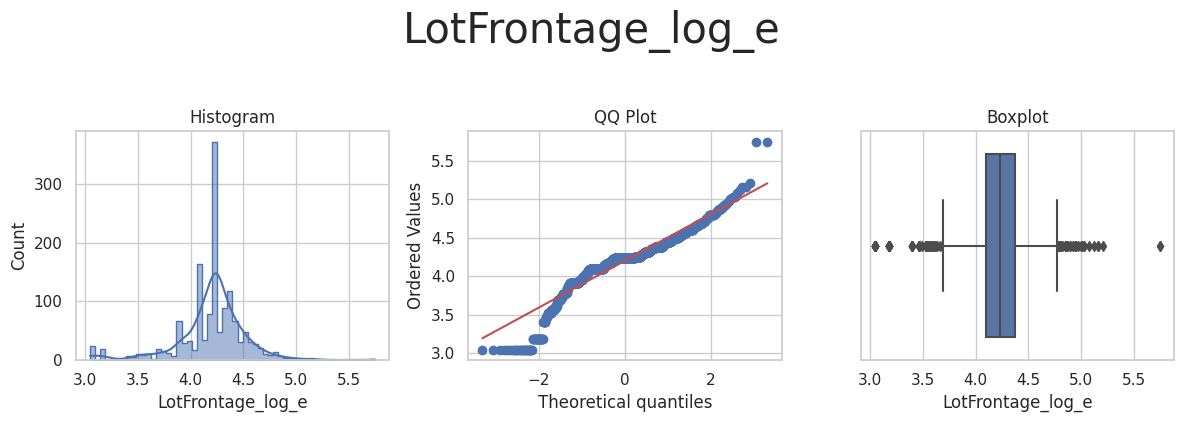

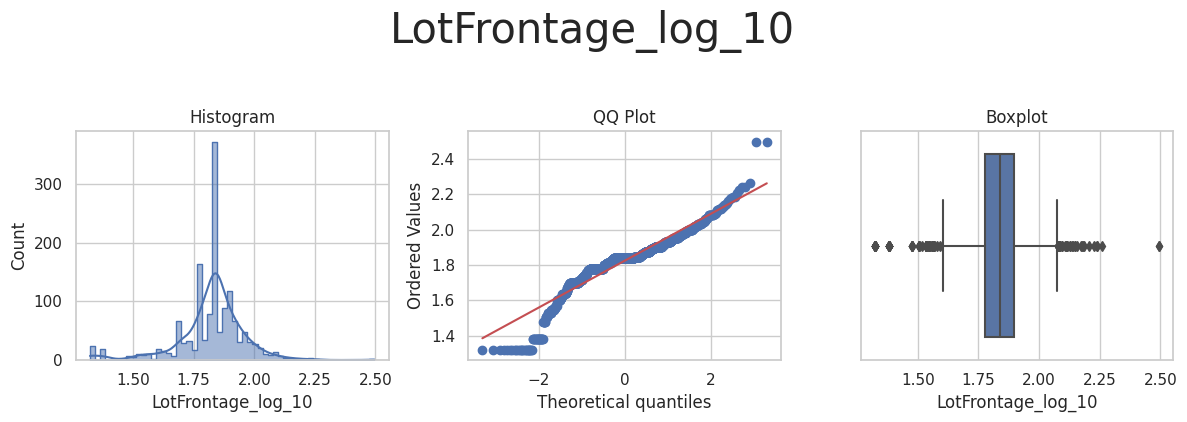

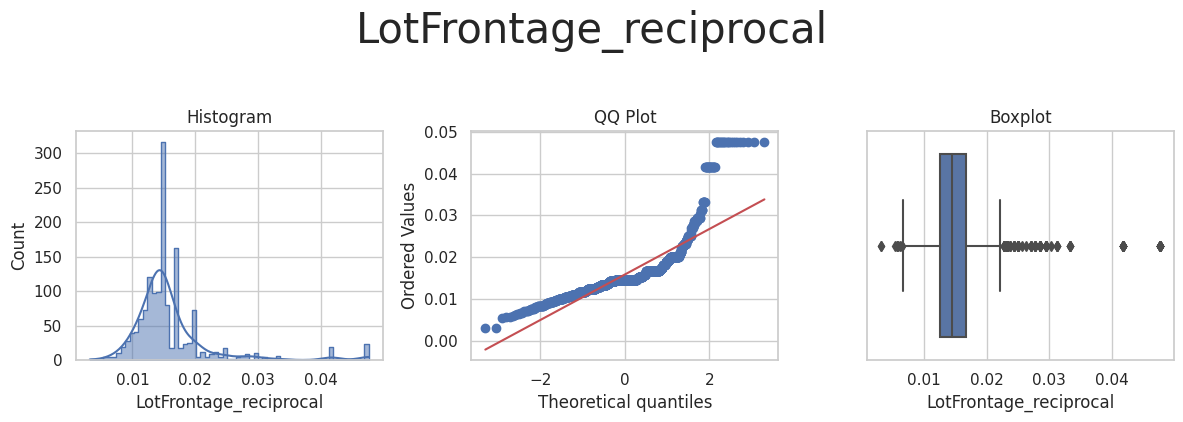

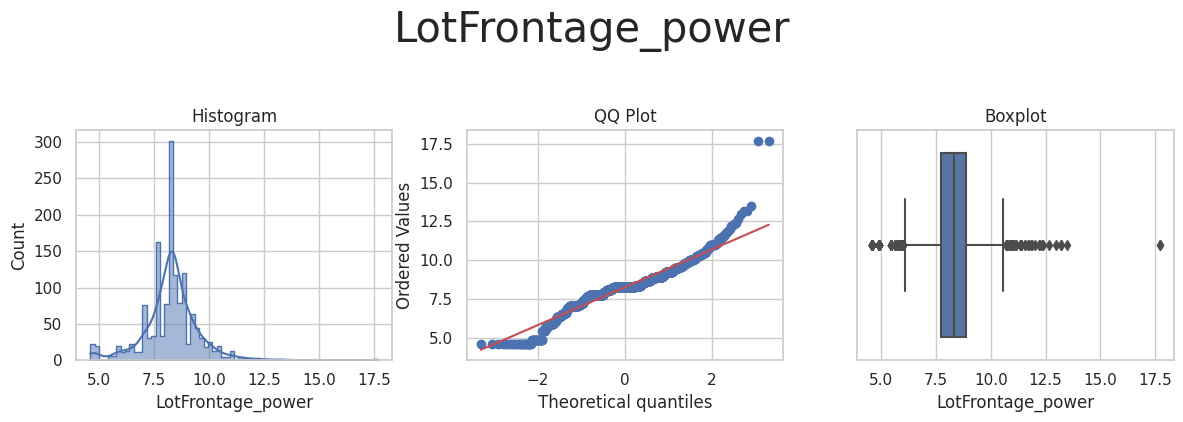

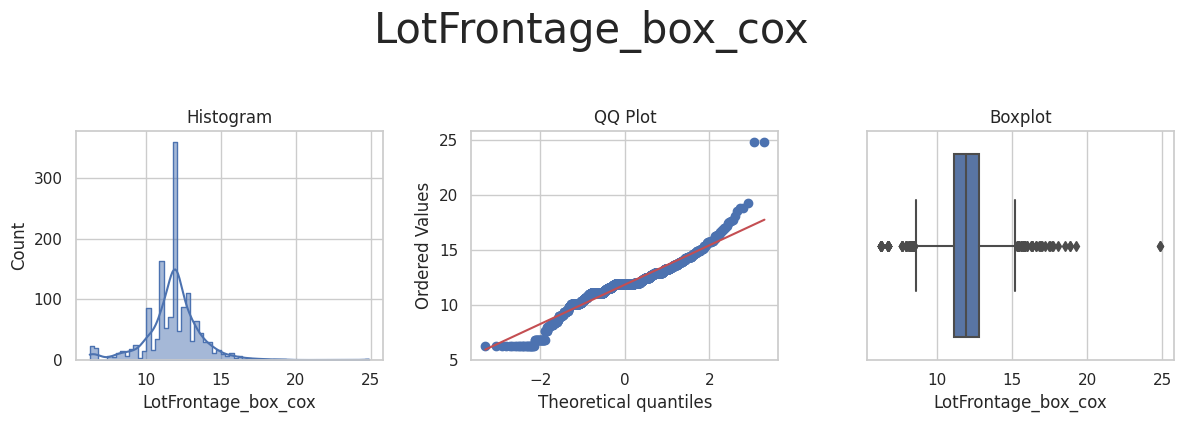

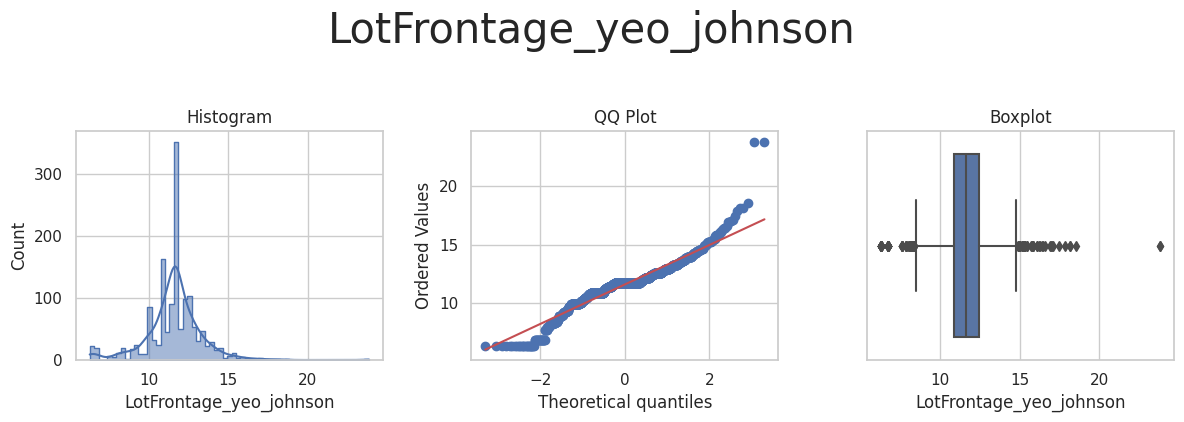



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



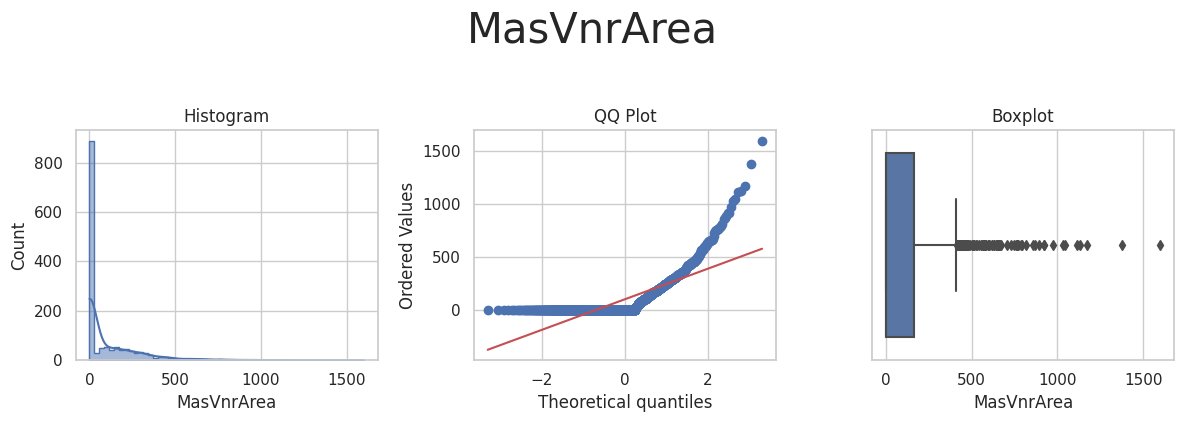

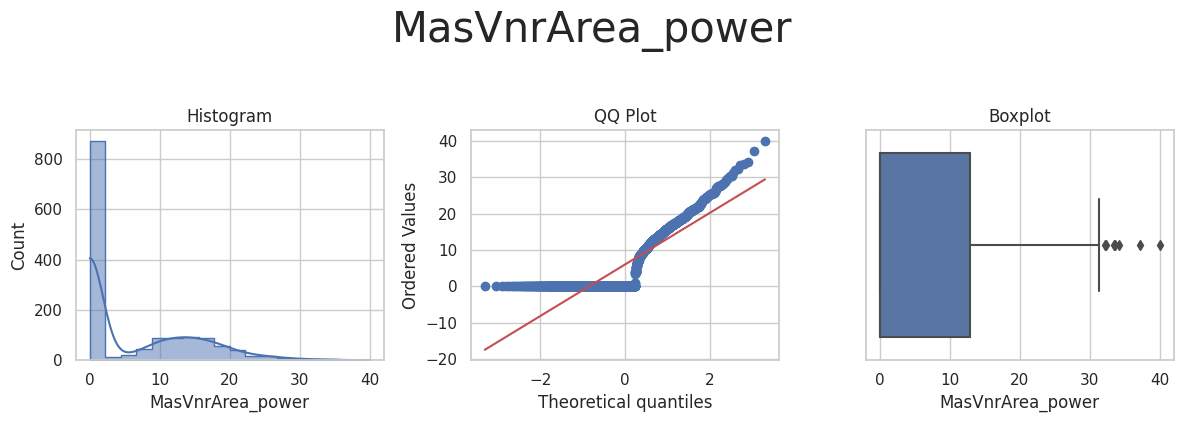

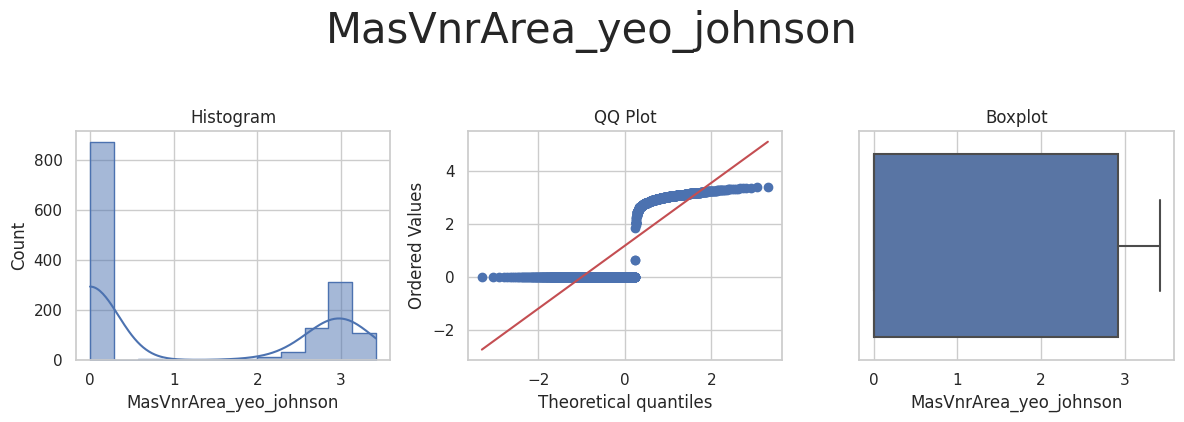



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



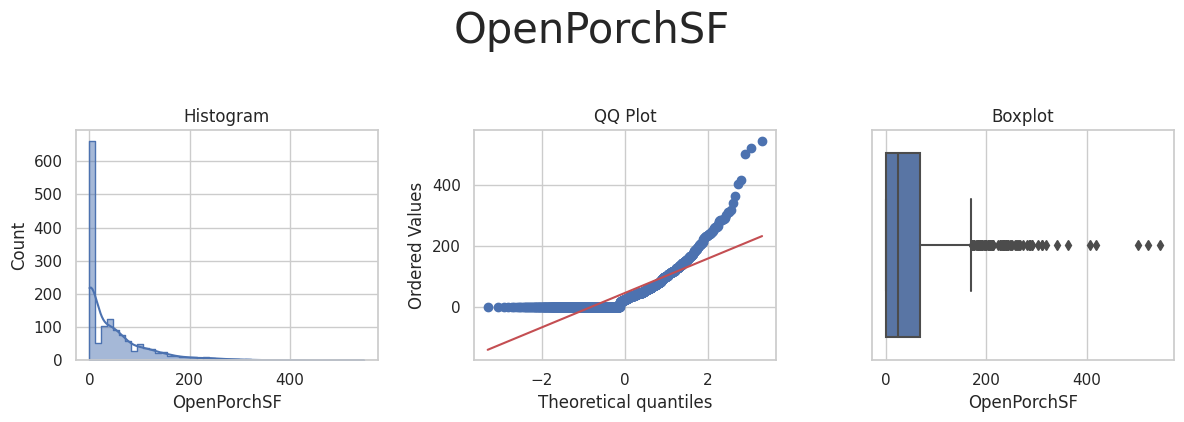

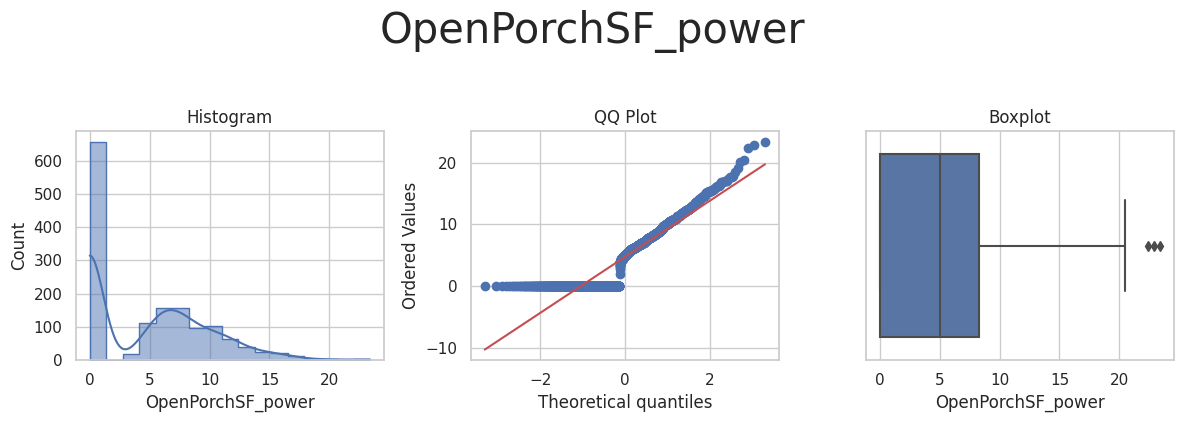

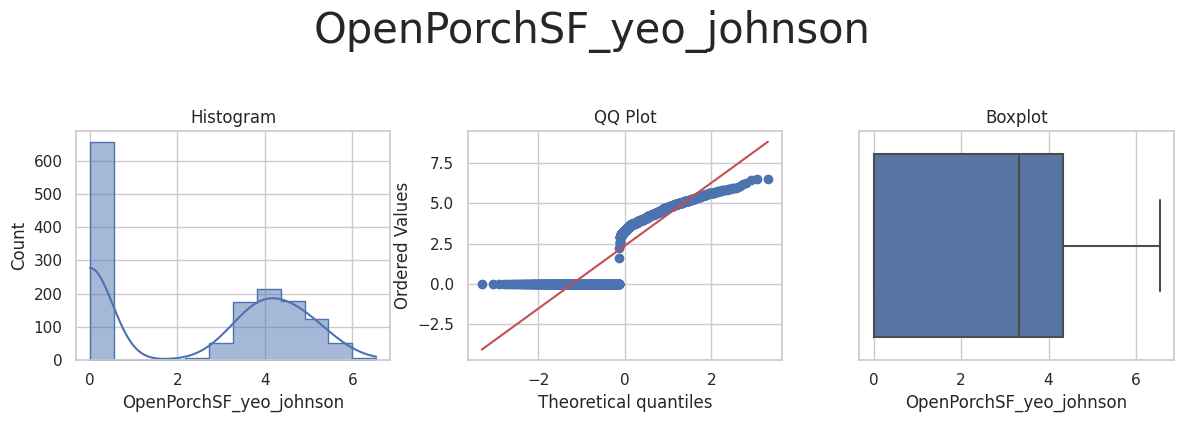



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



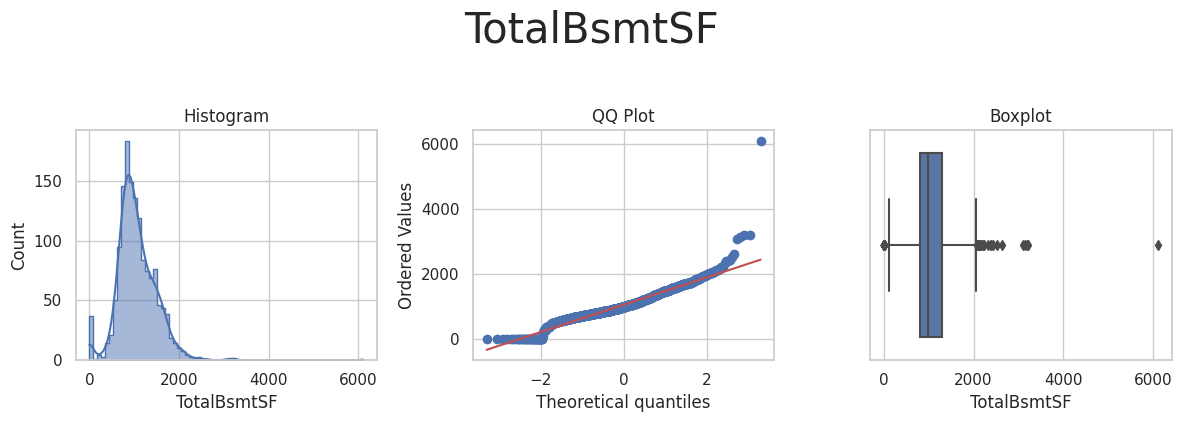

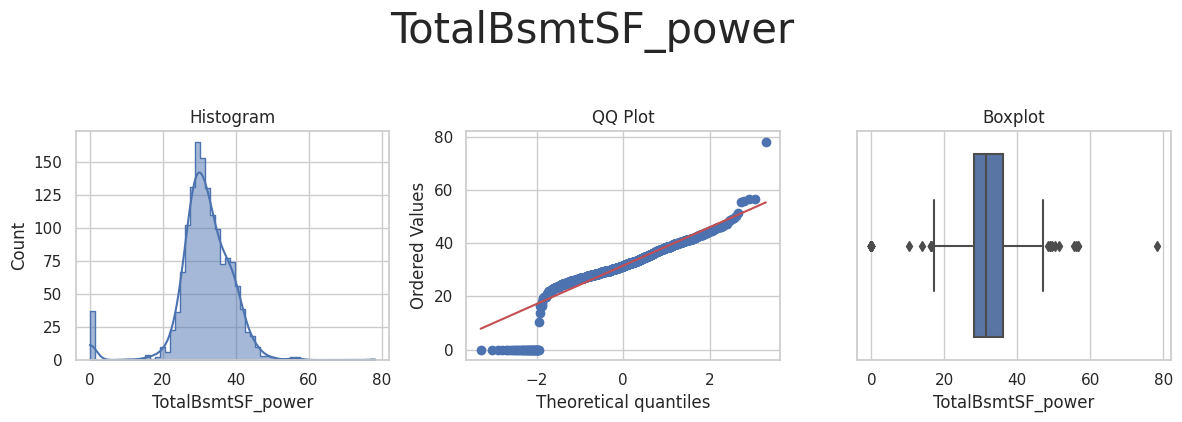

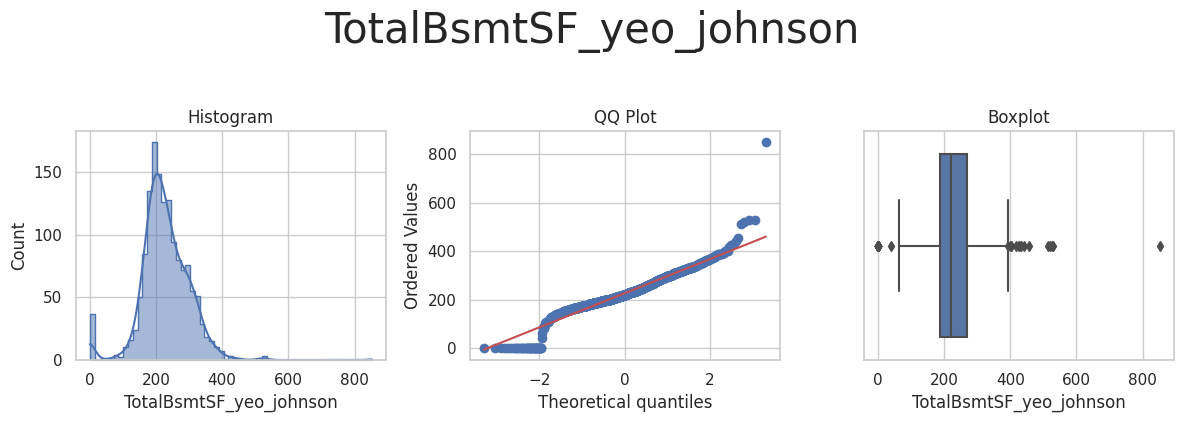

In [16]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* Check log_e tranformation on 'GrLivArea'

In [17]:
df_engineering[['GrLivArea', 'GrLivArea_log_e']].head(3)

,GrLivArea,GrLivArea_log_e
0,1710.0,7.444249
1,1262.0,7.140453
2,1786.0,7.487734


* The log_e transformation improves the QQ-plot of 'GrLivArea' subtantially. The power transformation improves 'BmstUnfSF' and 'OpenPorchSF' somewhat. The other variables are not improved by the transformations.

### Transform the target variable, i. e. the sale price

In [18]:
df_target = df['SalePrice'].to_frame()
df_target.head(3)

,SalePrice
0,208500.0
1,181500.0
2,223500.0


* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



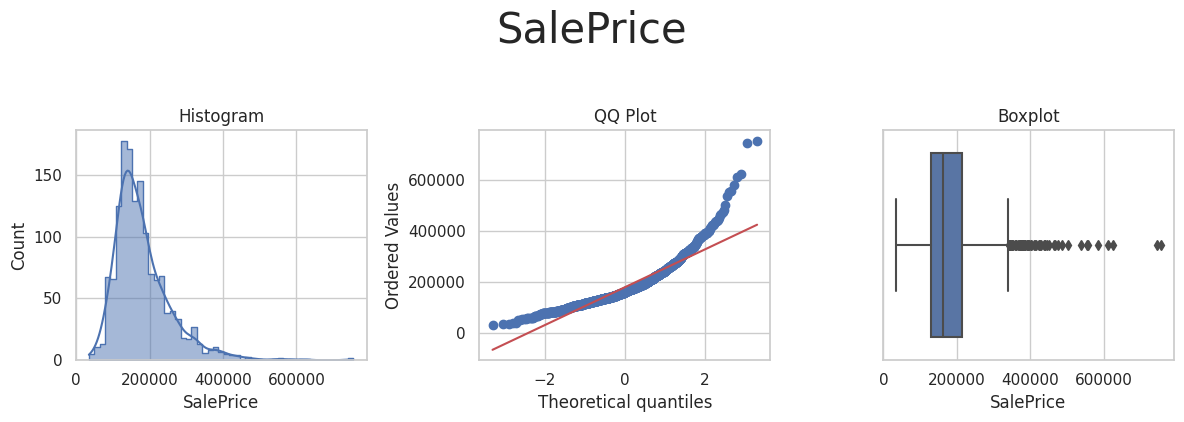

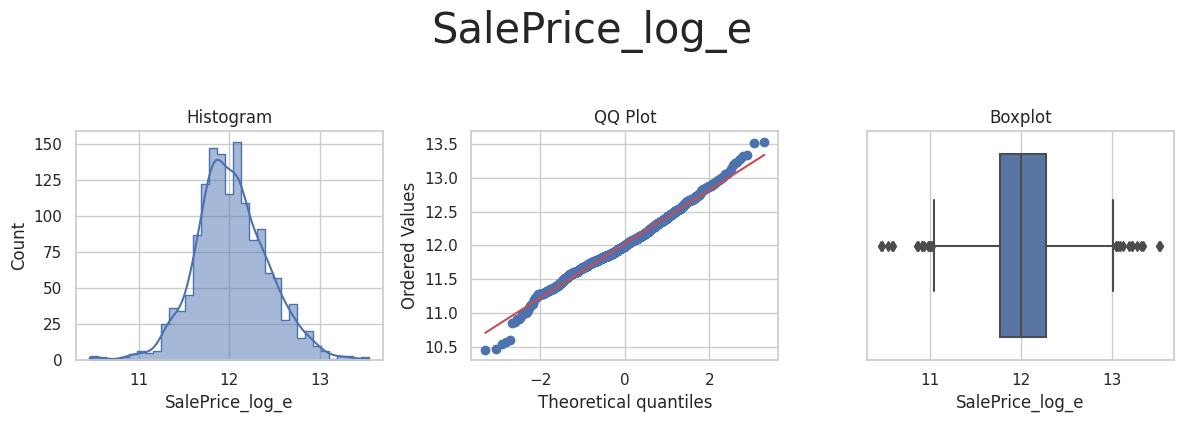

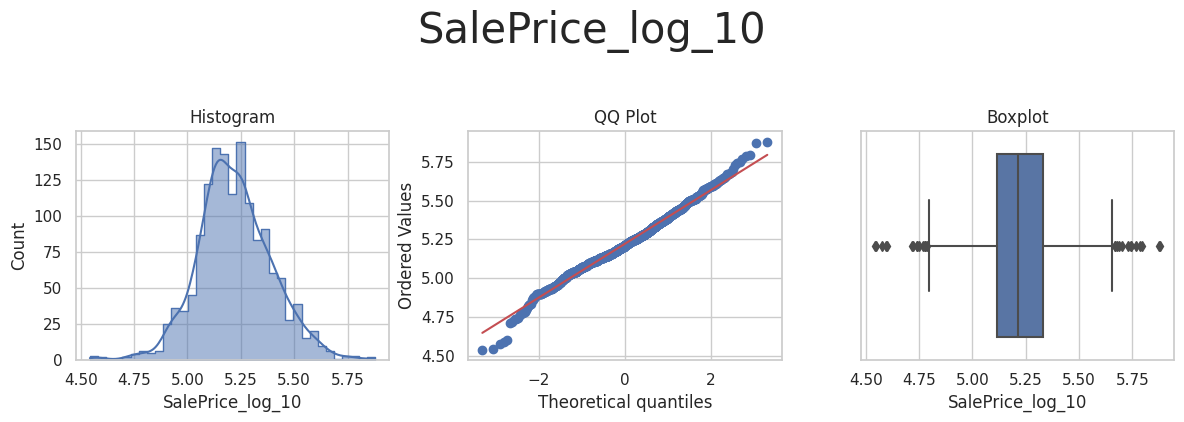

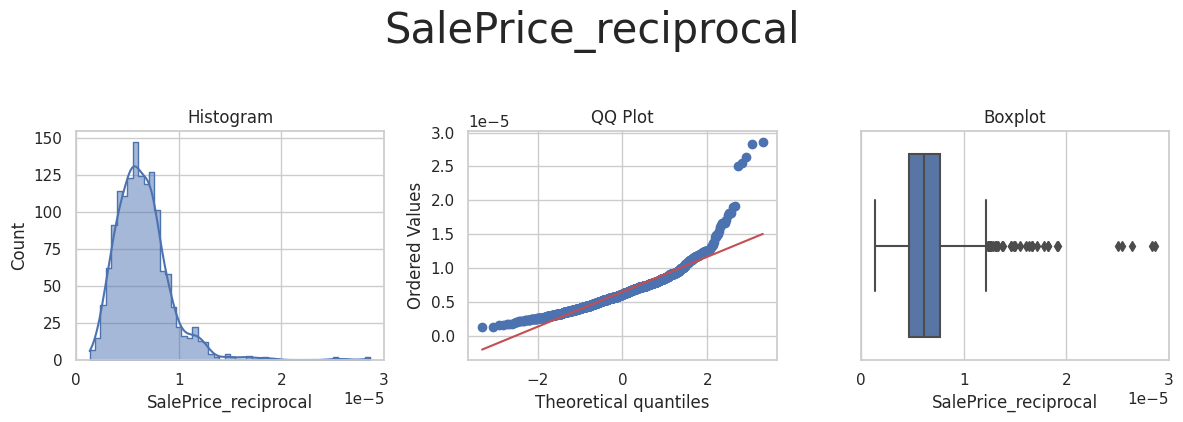

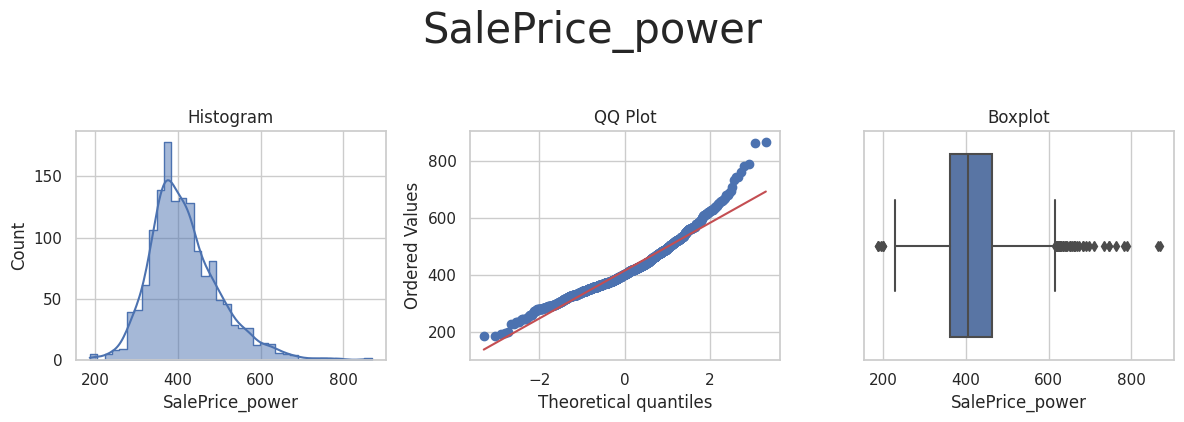

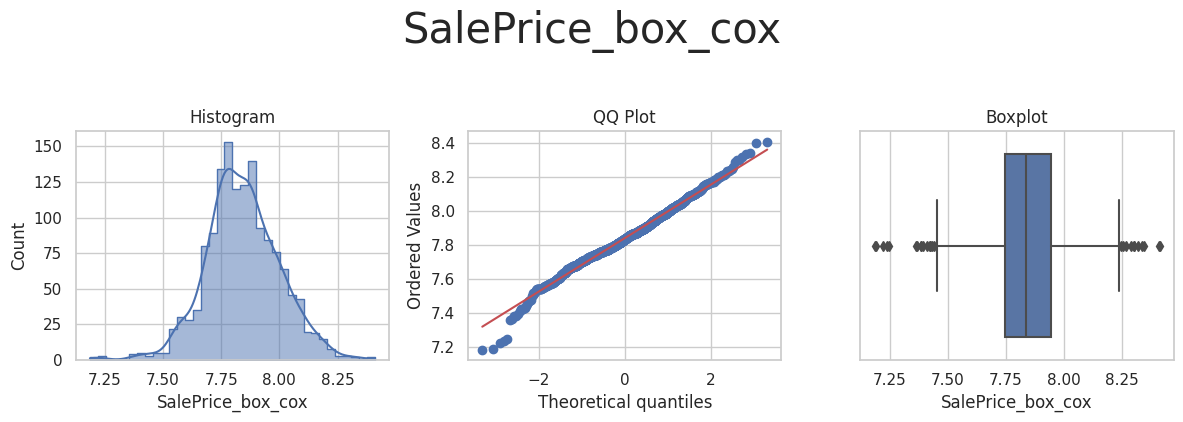

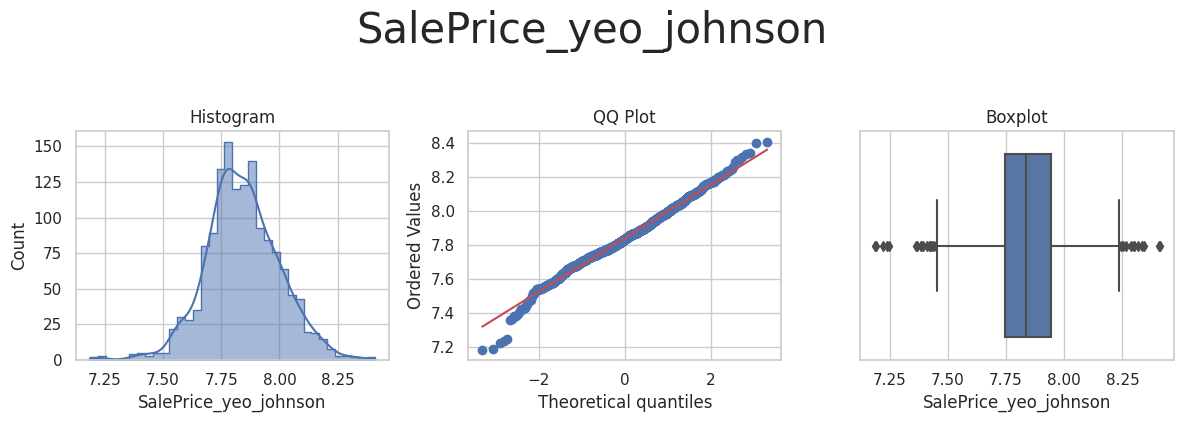

In [19]:
df_target = FeatureEngineeringAnalysis(df=df_target, analysis_type='numerical')

* The log_e, log, BoxCox and YeoJohnson improve the sale price distribution as can be seen from the QQ-plot.